In [1]:
!pip install pytorchcv

    100% |████████████████████████████████| 296kB 7.4MB/s ta 0:00:011


In [2]:
!pip install fastai==1.0.47

    100% |████████████████████████████████| 215kB 23.2MB/s ta 0:00:01
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'sample_submission.csv']


In [4]:
from pathlib import Path
import fastai
from fastai.vision import *
from pytorchcv.model_provider import get_model as ptcv_get_model

In [5]:
PATH = Path('../input/train/')
np.random.seed(42)

In [6]:
batch_size = 128

In [7]:
tfms = get_transforms(flip_vert=True,max_lighting=0.5,max_rotate=360.,max_warp=0.3)

In [8]:
src = (ImageList.from_folder(path=PATH)
            .split_by_rand_pct(0.05)
            .label_from_folder())

In [9]:
data = (src.transform(tfms,size=224)
          .databunch(bs=batch_size)
           .normalize(imagenet_stats))

In [ ]:
# data.show_batch(rows=3, figsize=(9, 9))

In [ ]:
# data.classes, data.c

In [10]:
def md(f=None):
    mdl = ptcv_get_model('condensenet74_c4_g4', pretrained=True)
    mdl.features.final_pool = nn.AvgPool2d(kernel_size=7, stride=1, padding=3)
    return mdl

In [11]:
learn = cnn_learner(data, md, metrics=accuracy, path='./')

In [12]:
# learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 16, 112, 112]    432        False     
______________________________________________________________________
BatchNorm2d          [1, 16, 112, 112]    32         True      
______________________________________________________________________
ReLU                 [1, 16, 112, 112]    0          False     
______________________________________________________________________
Conv2d               [1, 32, 112, 112]    128        False     
______________________________________________________________________
ChannelShuffle       [1, 32, 112, 112]    0          False     
______________________________________________________________________
BatchNorm2d          [1, 32, 112, 112]    64         True      
______________________________________________________________________
ReLU                 [1, 32, 112, 112]    0          False     
______________________________________________________________

In [13]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


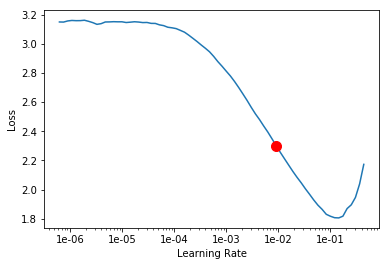

In [14]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(5,slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.299229,0.530877,0.831224,01:36
1,0.720237,0.337859,0.873418,01:37
2,0.472802,0.263496,0.907173,01:36
3,0.340395,0.227992,0.928270,01:35
4,0.259834,0.235554,0.919831,01:37


In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


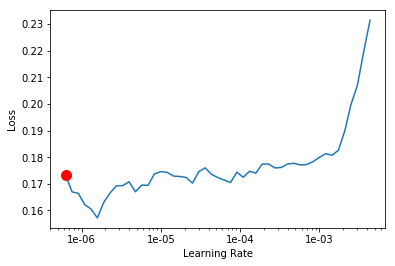

In [17]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(5,slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.185112,0.233531,0.928270,01:38
1,0.174835,0.235736,0.924051,01:38
2,0.183367,0.236051,0.915612,01:37
3,0.178817,0.235806,0.919831,01:37
4,0.179546,0.230479,0.924051,01:36


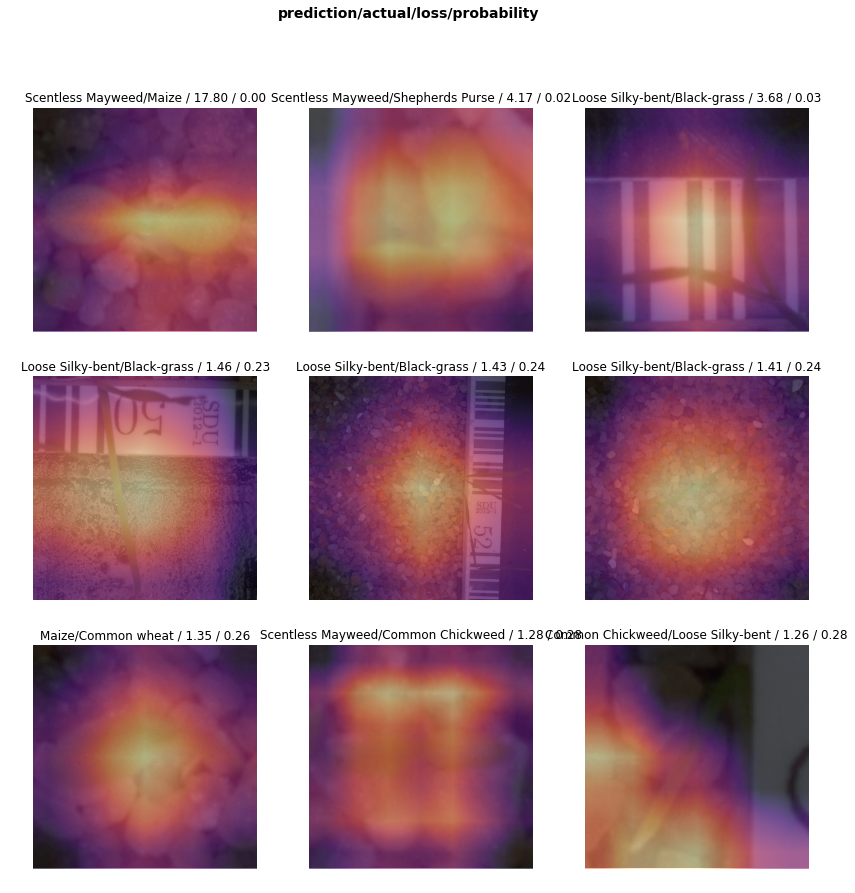

In [19]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(9, figsize=(14,14))

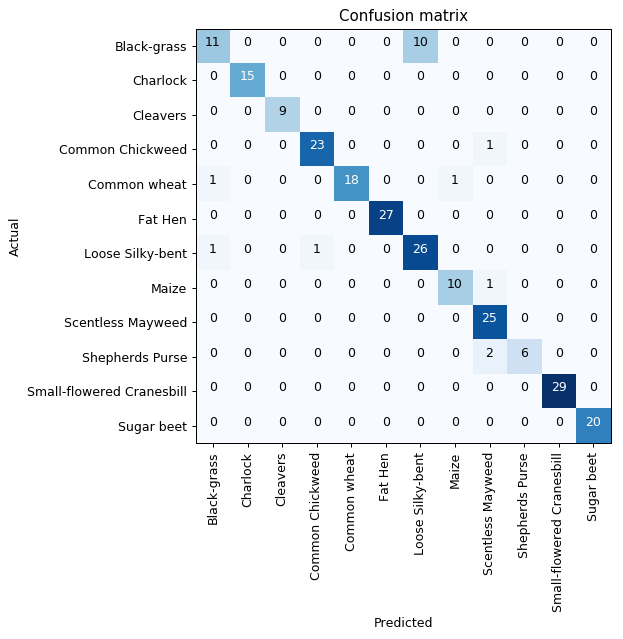

In [20]:
# interp.plot_confusion_matrix(figsize=(7, 7),dpi=90)

In [ ]:
test = ImageList.from_folder('../input/test/')

In [ ]:
learn.export()

In [ ]:
learn = load_learner(path='./', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
labelled_preds = [learn.data.classes[np.argmax(pred)] for pred in preds]

In [ ]:
fnames = [f.name for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'file':fnames, 'species':labelled_preds}, columns=['file', 'species'])

In [ ]:
df.to_csv('submission.csv', index=False)